In [2]:
import pandas as pd
import numpy as np
import ast

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

sns.set(style="whitegrid")


In [3]:
movies = pd.read_csv("movie_dataset.csv")
liked = pd.read_csv("liked_films.csv")

# Clean titles for matching
movies['title_clean'] = movies['title'].str.lower().str.strip()
liked['name_clean'] = liked['Name'].str.lower().str.strip()

# Target variable
movies['is_favorite'] = movies['title_clean'].isin(
    liked['name_clean']
).astype(int)

print("Favorite movies:", movies['is_favorite'].sum())
print("Total movies:", len(movies))


Favorite movies: 69
Total movies: 512


In [4]:
# Convert list-like columns
list_cols = ['genres', 'directors', 'cast']
for col in list_cols:
    movies[col] = movies[col].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else x
    )

# Convert numeric columns
movies['imdb_rating'] = pd.to_numeric(
    movies['imdb_rating'], errors='coerce'
)

movies['rt_rating'] = (
    movies['rt_rating']
    .astype(str)
    .str.replace('%', '', regex=False)
)
movies['rt_rating'] = pd.to_numeric(
    movies['rt_rating'], errors='coerce'
)


In [5]:
mlb_genre = MultiLabelBinarizer()
genre_features = mlb_genre.fit_transform(movies['genres'])

genre_df = pd.DataFrame(
    genre_features,
    columns=[f"genre_{g}" for g in mlb_genre.classes_]
)


In [ ]:
TOP_K_DIRECTORS = 15

top_directors = (
    movies['directors']
    .explode()
    .value_counts()
    .head(TOP_K_DIRECTORS)
    .index
)

for d in top_directors:
    movies[f"director_{d}"] = movies['directors'].apply(
        lambda x: int(d in x)
    )



In [15]:
TOP_K_ACTORS = 20

top_actors = (
    movies['cast']
    .explode()
    .value_counts()
    .head(TOP_K_ACTORS)
    .index
)

for actor in top_actors:
    movies[f"actor_{actor}"] = movies['cast'].apply(
        lambda x: int(actor in x)
    )


In [13]:
num_features = movies[
    [ 'imdb_rating', 'rt_rating',
     'oscar_wins', 'oscar_nominations']
].fillna(0)


In [16]:
actor_cols = [f"actor_{a}" for a in top_actors]
director_cols = [f"director_{d}" for d in top_directors]

X = pd.concat([
    num_features.reset_index(drop=True),
    genre_df.reset_index(drop=True),
    movies[director_cols + actor_cols].reset_index(drop=True)
], axis=1)

y = movies['is_favorite']

print("Feature count:", X.shape[1])


Feature count: 53


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,                
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

scaler = StandardScaler()

# 🔧 SCALE but KEEP feature names
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X.columns,
    index=X_train.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X.columns,
    index=X_test.index
)

log_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

log_model.fit(X_train_scaled, y_train)

y_pred_log = log_model.predict(X_test_scaled)

print("Logistic Regression Accuracy:",
      accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))



Logistic Regression Accuracy: 0.625
              precision    recall  f1-score   support

           0       0.85      0.68      0.76       111
           1       0.10      0.24      0.14        17

    accuracy                           0.62       128
   macro avg       0.48      0.46      0.45       128
weighted avg       0.75      0.62      0.68       128



In [29]:
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight='balanced'
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:",
      accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.8515625
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       111
           1       0.00      0.00      0.00        17

    accuracy                           0.85       128
   macro avg       0.43      0.49      0.46       128
weighted avg       0.75      0.85      0.80       128



In [30]:
# Logistic Regression coefficients
coef_df = pd.Series(
    log_model.coef_[0],
    index=X.columns
).sort_values(ascending=False)

coef_df.head(10)


# Random Forest feature importance
importances = pd.Series(
    rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

importances.head(10)


rt_rating            0.206404
imdb_rating          0.187800
oscar_nominations    0.060915
oscar_wins           0.058139
genre_Comedy         0.042899
genre_Drama          0.032468
genre_Crime          0.030601
genre_Thriller       0.028018
genre_Romance        0.025571
genre_Adventure      0.024107
dtype: float64

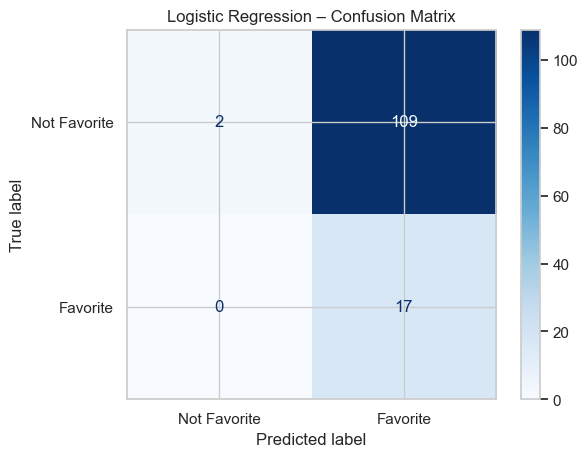

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = log_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Not Favorite", "Favorite"]
)

disp.plot(cmap="Blues")
plt.title("Logistic Regression – Confusion Matrix")
plt.show()


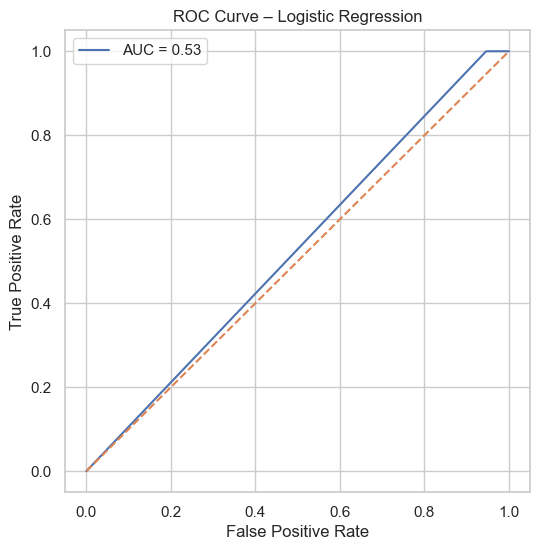

In [32]:
from sklearn.metrics import roc_curve, auc

y_prob = log_model.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression")
plt.legend()
plt.show()


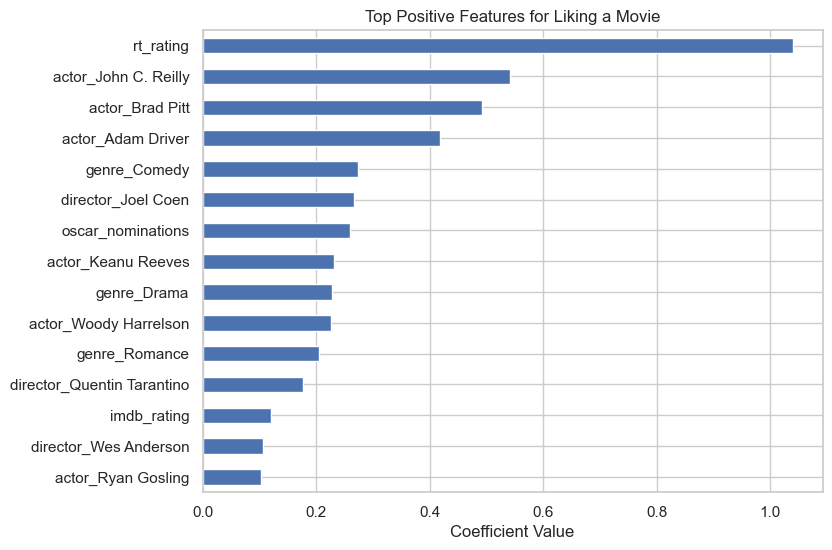

In [33]:
top_features = coef_df.head(15)

plt.figure(figsize=(8,6))
top_features.sort_values().plot(kind="barh")
plt.title("Top Positive Features for Liking a Movie")
plt.xlabel("Coefficient Value")
plt.show()


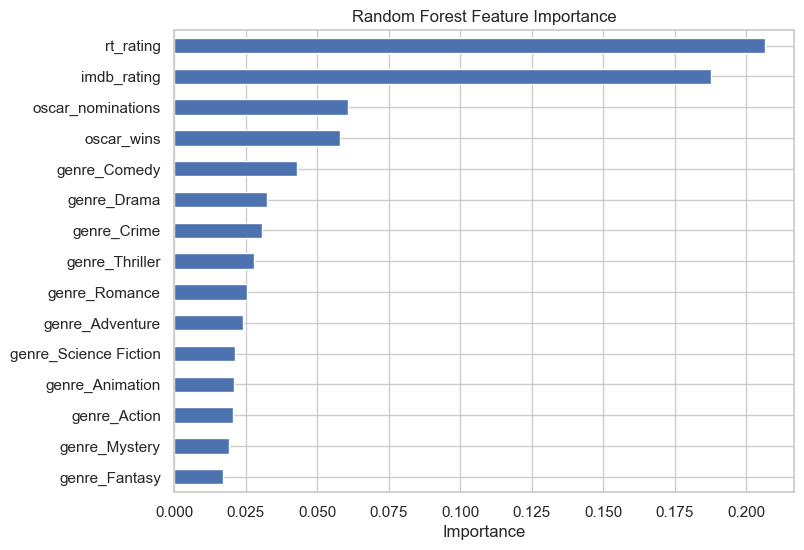

In [34]:
top_rf = importances.head(15)

plt.figure(figsize=(8,6))
top_rf.sort_values().plot(kind="barh")
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.show()
